# Loading the data

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


In [96]:
date_cols = ['Date']
df = pd.read_csv("/Users/sasha/Desktop/DATASCIENCE/2023/Mini-Project/data.nosync/clean_data_set_2.csv", dtype={'Account':str}, index_col=0, parse_dates=date_cols)
df = df[df.Amount < 0]
df.head()

,Account,Amount,Balance,to_account,to_name,Date,Time,Transaction_ID,Decimal_time,Income,Employment,Day_type,Day
98,1381,-850.0,2656.70,1036.0,Between,2020-01-01,00:00:00,99,0.0,4414.23,Employed,weekday,Wednesday
100,1444,-800.0,2508.76,1036.0,Between,2020-01-01,00:00:00,101,0.0,4444.92,Employed,weekday,Wednesday
102,1138,-500.0,759.27,1036.0,Between,2020-01-01,00:00:00,103,0.0,NaN,Unemployed,weekday,Wednesday
104,1312,-600.0,2993.06,1091.0,Between,2020-01-01,00:00:00,105,0.0,NaN,Unemployed,weekday,Wednesday
106,1070,-775.0,3028.96,142.0,Between,2020-01-01,00:00:00,107,0.0,4163.39,Employed,weekday,Wednesday


In [97]:
class_labels = pd.read_csv("/Users/sasha/Desktop/DATASCIENCE/2023/Mini-Project/data.nosync/class_labels.csv")
class_labels = class_labels[['Account Number', 'Cluster']]
class_labels = class_labels.rename(columns={class_labels.columns[0]: 'Account'})
class_labels.head()

,Account,Cluster
0,1000,2
1,1001,0
2,1002,0
3,1003,0
4,1004,0


### Any obvious outliers?

In [3]:
from sklearn.ensemble import IsolationForest
anomalies_df_obv = pd.DataFrame(columns=['Account', 'Transaction_ID', 'scores', 'anomaly'])
anomalies_df_obv[['Account', 'Transaction_ID']] = df[['Account', 'Transaction_ID']]
iForest=IsolationForest(n_estimators=100,max_features=1.0)
iForest.fit(np.array(df['Amount']).reshape(-1,1)) 
anomalies_df_obv['anomaly']=iForest.predict(np.array(df['Amount']).reshape(-1,1))

anomalies_obv = df[anomalies_df_obv['anomaly'] == -1]['Amount']
nonanomalies_obv = df[anomalies_df_obv['anomaly'] == 1]['Amount']


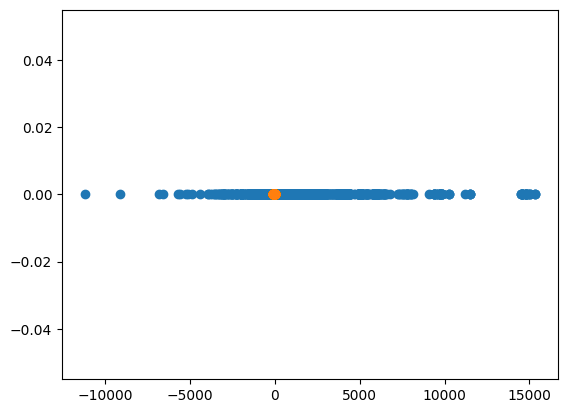

In [155]:

plt.scatter(np.array(anomalies_obv), np.zeros_like(anomalies_obv))
plt.scatter(np.array(nonanomalies_obv), np.zeros_like(nonanomalies_obv))
plt.show()

# Adding features

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 174601 entries, 0 to 174600
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Account         174601 non-null  object        
 1   Amount          174601 non-null  float64       
 2   Balance         174601 non-null  float64       
 3   to_account      174601 non-null  object        
 4   to_name         174601 non-null  object        
 5   Date            174601 non-null  datetime64[ns]
 6   Time            174601 non-null  object        
 7   Transaction_ID  174601 non-null  int64         
 8   Decimal_time    174601 non-null  float64       
 9   Income          95107 non-null   float64       
 10  Employment      174601 non-null  object        
 11  Day_type        174601 non-null  object        
 12  Day             174601 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(7)
memory usage: 18.6+ MB


In [98]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()  
transformed = ohe.fit_transform(df[['Day_type']])
df[ohe.categories_[0]] = transformed.toarray()

In [99]:
bank_holiday_indexes = df[(df.Date == '2020-01-01')].index
df.loc[bank_holiday_indexes, "weekday"] = 0
df.drop(['Day_type', 'weekend'], axis = 1, inplace= True)

In [100]:
df['Month'] = df['Date'].apply(lambda x: x.month)
df['Day'] = df['Date'].apply(lambda x: x.day)


In [101]:
df['Absoulute_time'] = df['Date'].apply(lambda x: ((((x.month-1)*31)+(x.day-1))*24) if x.month != 3 else ((((28+31)+(x.day-1))*24)))
df['Absoulute_time'] = df['Absoulute_time']+ df['Decimal_time']

In [102]:
df['Account'] = df['Account'].astype(int)
df = pd.DataFrame.merge(df, class_labels, on = 'Account')

### The following features trens and time_diff are from my research they allow us to bring as much information possible into our model

In [103]:
df['Trend'] = 0
df['Time_diff'] = 0
customer_list  = df.Account.unique()
for customer in customer_list:
    customer_indexes = df[(df['Account'] == customer)].index
    temp_df = df[df.Account == customer][['Amount', 'Trend', 'Absoulute_time', 'Time_diff']]
    temp_df['Trend'] = -temp_df['Amount'].diff(1)/temp_df.Amount.shift(1)
    temp_df['Time_diff'] = temp_df['Absoulute_time'].diff(1)
    df.loc[customer_indexes, "Trend"] = temp_df.Trend
    df.loc[customer_indexes, "Time_diff"] = temp_df.Time_diff

In [104]:
df['Trend']=df['Trend'].fillna(0)
df['Time_diff']=df['Time_diff'].fillna(0)

In [105]:
buisness_spenniness = df.groupby('to_name').agg({'Amount': np.mean}).reset_index()
list_of_means = np.array(buisness_spenniness['Amount'])
buisness_spenniness['percentile_of_business']= buisness_spenniness['Amount'].apply(lambda x: round(stats.percentileofscore(list_of_means, x), -1))

In [106]:
df = pd.merge(df, buisness_spenniness[['to_name', 'percentile_of_business']], on='to_name')
transformed = ohe.fit_transform(df[['Cluster']])
df[ohe.categories_[0]] = transformed.toarray()

# Fraud detection by running an fraud detection algorithm directly on each accounts transaction data
### We must visualise/checl what the algorithms are doing to see if they are picking out reasonable anomalies
- Isolation forests
- SVM
- LOF
- Voting system combining the 3 above

### Pre-processing

In [70]:
df.columns

Index([               'Account',                 'Amount',
                      'Balance',             'to_account',
                      'to_name',                   'Date',
                         'Time',         'Transaction_ID',
                 'Decimal_time',                 'Income',
                   'Employment',                    'Day',
                      'weekday',                  'Month',
               'Absoulute_time',                'Cluster',
                        'Trend',              'Time_diff',
       'percentile_of_business',                        0,
                              1,                        2,
                              3],
      dtype='object')

In [107]:
from sklearn import preprocessing
df_fraud = df.drop(['Account', 'to_account', 'to_name', 'Date', 'Time', 'Transaction_ID', 'Employment', 'Income', 'Day', 'Month', 'Absoulute_time', 'Cluster'], axis=1)

std_scale = preprocessing.StandardScaler().fit(df_fraud)
train_norm = std_scale.transform(df_fraud)
training_norm_col = pd.DataFrame(train_norm, index=df_fraud.index, columns=df_fraud.columns) 
df_fraud.update(training_norm_col)
df_fraud.head()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int64', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int64', 'str']. An error will be raised in 1.2.
  warnings.warn(


,Amount,Balance,Decimal_time,weekday,Trend,Time_diff,percentile_of_business,0,1,2,3
0,-7.502333,0.843403,-2.552375,-1.463070,0.177120,-0.669006,-2.166367,-0.917146,-0.170168,1.077791,-0.23511
1,0.132065,0.830720,1.510060,-1.463070,0.140708,-0.651929,-2.166367,-0.917146,-0.170168,1.077791,-0.23511
2,0.076960,0.753841,-1.308096,0.683494,0.198810,0.350266,-2.166367,-0.917146,-0.170168,1.077791,-0.23511
3,0.242089,0.711584,0.363294,-1.463070,0.218633,-0.258095,-2.166367,-0.917146,-0.170168,1.077791,-0.23511
4,0.248977,0.739848,0.962031,-1.463070,0.205240,-0.125750,-2.166367,-0.917146,-0.170168,1.077791,-0.23511


# Isolation forests

In [77]:
from sklearn.ensemble import IsolationForest
anomalies_df_IF = pd.DataFrame(columns=['Account', 'Transaction_ID', 'scores', 'anomaly'])
anomalies_df_IF[['Account', 'Transaction_ID']] = df[['Account', 'Transaction_ID']]
temp = df_fraud
iForest=IsolationForest(n_estimators=100,max_features=1.0, contamination=1/100)
iForest.fit(temp) 
anomalies_df_IF['scores']=iForest.decision_function(temp)
anomalies_df_IF['anomaly']=iForest.predict(temp)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int64', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int64', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int64', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [66]:
print(anomalies_df_IF[anomalies_df_IF.anomaly == -1].shape[0] + anomalies_df_IF[anomalies_df_IF.anomaly == 1].shape[0] == df.shape[0])
print('We have classified', anomalies_df_IF[anomalies_df_IF.anomaly == -1].shape[0]/df.shape[0], 'proportion of the data as anomalies')

True
We have classified 0.0010044387773514092 proportion of the data as anomalies


### Isoloation forests gives 14% of the data as anomalies

# One class SVM

In [23]:
from sklearn.svm import OneClassSVM
anomalies_df_SVM = pd.DataFrame(columns=['Account', 'Transaction_ID', 'scores', 'anomaly'])
anomalies_df_SVM[['Account', 'Transaction_ID']] = df[['Account', 'Transaction_ID']]
temp = df_fraud
ocsvm=OneClassSVM()
ocsvm.fit(temp) 
anomalies_df_SVM['scores']=ocsvm.decision_function(temp)
anomalies_df_SVM['anomaly']=ocsvm.predict(temp)


In [30]:
print(anomalies_df_SVM[anomalies_df_SVM.anomaly == -1].shape[0] + anomalies_df_SVM[anomalies_df_SVM.anomaly == 1].shape[0] == df.shape[0])
print('We have classified', anomalies_df_SVM[anomalies_df_SVM.anomaly == -1].shape[0]/df.shape[0], 'proportion of the data as anomalies')

True
We have classified 0.5 proportion of the data as anomalies


### 50% of the data is classified as anomalous, this is of course way too high

# LOF (Local Oulier Factor)

In [74]:
from sklearn.neighbors import LocalOutlierFactor
anomalies_df_LOF = pd.DataFrame(columns=['Account', 'Transaction_ID', 'scores', 'anomaly'])
anomalies_df_LOF[['Account', 'Transaction_ID']] = df[['Account', 'Transaction_ID']]
temp = df_fraud
lof=LocalOutlierFactor(novelty=True)
lof.fit(temp) 
anomalies_df_LOF['scores']=lof.decision_function(temp)
anomalies_df_LOF['anomaly']=lof.predict(temp)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int64', 'str']. An error will be raised in 1.2.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
print(anomalies_df_LOF[anomalies_df_LOF.anomaly == -1].shape[0] + anomalies_df_LOF[anomalies_df_LOF.anomaly == 1].shape[0] == df.shape[0])
print('We have classified', anomalies_df_LOF[anomalies_df_LOF.anomaly == -1].shape[0]/df.shape[0], 'proportion of the data as anomalies')

True
We have classified 0.014838026728897764 proportion of the data as anomalies


### 9% of the data is classified as anomalies

# Voting system

In [ ]:
anomalies_df_voting = pd.DataFrame(columns=['Account', 'Transaction_ID','anomaly'])
anomalies_df_voting['anomaly'] =  anomalies_df_IF.anomaly + anomalies_df_LOF.anomaly + anomalies_df_SVM.anomaly

In [ ]:
anomalies_df_voting['anomaly'] = anomalies_df_voting['anomaly'].apply(lambda x: -1 if x == -3 else 1)

In [ ]:
print(anomalies_df_voting[anomalies_df_voting.anomaly == -1].shape[0] + anomalies_df_voting[anomalies_df_voting.anomaly == 1].shape[0] == df.shape[0])
print('We have classified', anomalies_df_voting[anomalies_df_voting.anomaly == -1].shape[0]/df.shape[0], 'proportion of the data as anomalies')

True
We have classified 0.005124442145529345 proportion of the data as anomalies


### Using a voting system, where all algo must detect the transactions as an anomlay we get 3% of transactions as anomalous

### Let's visualise

In [114]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA



def three_d_plot(metrics_df, outlier_index):
    to_model_columns = metrics_df.columns
    pca = PCA(n_components=3)  # Reduce to k=3 dimensions
    scaler = StandardScaler()
    #normalize the metrics
    X = scaler.fit_transform(metrics_df[to_model_columns])
    X_reduce = pca.fit_transform(X)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_zlabel("PCA Principal Components")
    # Plot the compressed data points    
    ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
    # Plot x's for the ground truth outliers
    ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
            lw=2, s=60, marker="x", c="red", label="outliers")
    ax.legend()
    plt.show()

def two_d_plot(metrics_df, outlier_index):
    X = metrics_df.values

    # Perform PCA to reduce the dimensionality of the data
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    fig, ax = plt.subplots()
    ax.scatter(X_pca[:,0][~np.isin(np.arange(len(metrics_df)), outlier_index)], X_pca[:,1][~np.isin(np.arange(len(df)), outlier_index)], c='g', label='inliers')
    ax.scatter(X_pca[:,0][np.isin(np.arange(len(metrics_df)), outlier_index)], X_pca[:,1][np.isin(np.arange(len(df)), outlier_index)], c='r', marker='x', label='outliers')
    ax.legend()
    plt.show()



def visualise(metrics_df, outlier_index):
    three_d_plot(metrics_df, outlier_index)
    two_d_plot(metrics_df, outlier_index)



In [19]:
for anomalies_df in [[anomalies_df_IF, 'IsolationForest'], [anomalies_df_LOF, 'LocalOutlierFactor'], [anomalies_df_SVM, 'OneClassSVM'], [anomalies_df_voting, 'Voting']]:
    print('Evaluating model', anomalies_df[1])
    anomaly_model = anomalies_df[0]
    visualise(df_fraud, anomaly_model[anomaly_model.anomaly == -1].index)

NameError: name 'anomalies_df_LOF' is not defined

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int64', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int64', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int64', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names 

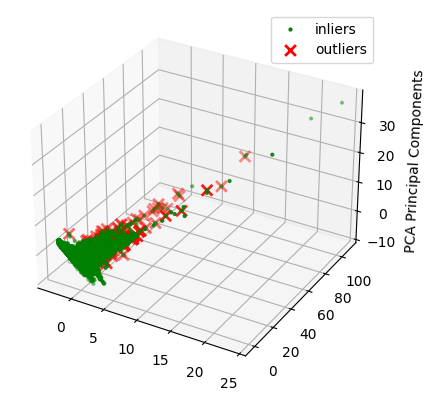

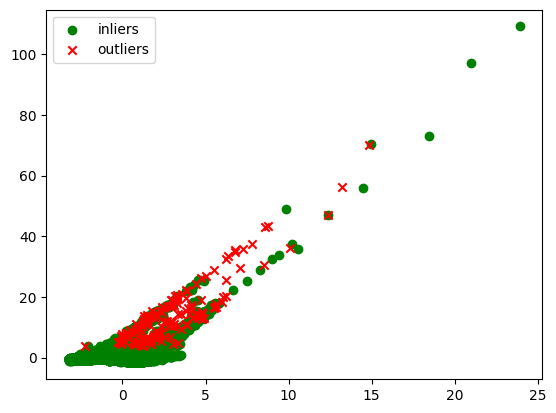

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int64', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int64', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int64', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names 

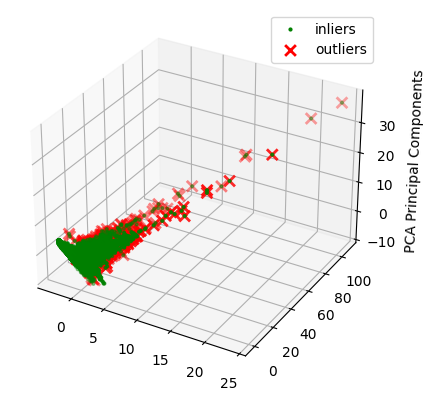

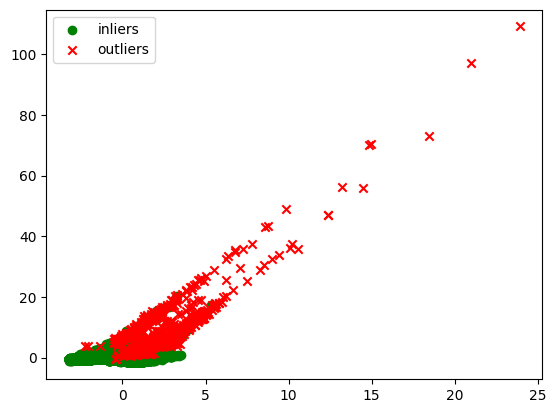

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int64', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int64', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int64', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names 

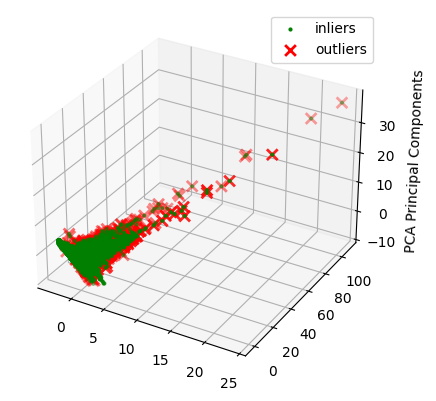

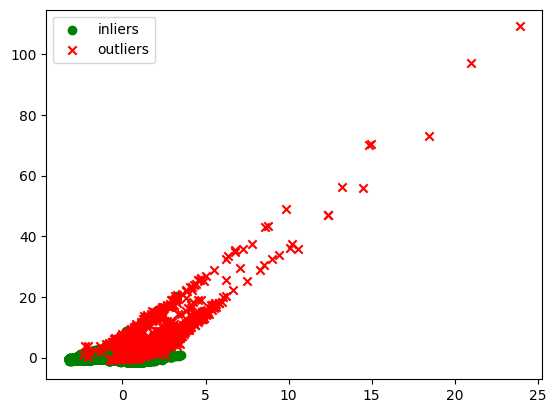

In [117]:
anomalies_df_IF = pd.DataFrame(columns=['Account', 'Transaction_ID', 'scores', 'anomaly'])
anomalies_df_IF[['Account', 'Transaction_ID']] = df[['Account', 'Transaction_ID']]
temp = df_fraud
for i in [1/1000,5/1000,10/1000]:
    iForest=IsolationForest(n_estimators=100,max_features=1.0, contamination=i)
    iForest.fit(temp) 
    anomalies_df_IF['scores']=iForest.decision_function(temp)
    anomalies_df_IF['anomaly']=iForest.predict(temp)
    visualise(df_fraud, anomalies_df_IF[anomalies_df_IF.anomaly == -1].index)

## No model here out of the box is clearly the best. 
## OCSVM classify way too many points, and the other 2 also classify slightly too many points
## The good news, is all seem to pick off the obvious outliers
## So far the voting seems to be the best as it picks off obvious outliers but doe not flag of too many transactions

# Auto encoder

In [119]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Load data (assuming it's stored in a numpy array called "data")
data = df_fraud

# Define the input shape
input_shape = (11,)

# Define the size of the encoded representation

# Define the input layer
input_layer = Input(shape=input_shape)

# Define the encoder layers
encoded = Dense(8, activation="relu")(input_layer)
encoded = Dense(4, activation="relu")(encoded)

# Define the decoder layers
decoded = Dense(8, activation="relu")(encoded)
decoded = Dense(input_shape[0], activation="sigmoid")(decoded)

# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compile the model
autoencoder.compile(optimizer="adam", loss="mse")

# Train the model
autoencoder.fit(data, data, epochs=50, batch_size=32)

# Use the trained autoencoder to detect fraud
decoded_data = autoencoder.predict(data)


Epoch 1/50
5196/5196 [==============================] - 17s 3ms/step - loss: 0.7635
Epoch 2/50
5196/5196 [==============================] - 15s 3ms/step - loss: 0.7190
Epoch 3/50
5196/5196 [==============================] - 15s 3ms/step - loss: 0.7147
Epoch 4/50
5196/5196 [==============================] - 13s 3ms/step - loss: 0.7122
Epoch 5/50
5196/5196 [==============================] - 14s 3ms/step - loss: 0.7113
Epoch 6/50
5196/5196 [==============================] - 13s 3ms/step - loss: 0.7109
Epoch 7/50
5196/5196 [==============================] - 14s 3ms/step - loss: 0.7107
Epoch 8/50
5196/5196 [==============================] - 13s 3ms/step - loss: 0.7106
Epoch 9/50
5196/5196 [==============================] - 14s 3ms/step - loss: 0.7105
Epoch 10/50
5196/5196 [==============================] - 17s 3ms/step - loss: 0.7104
Epoch 11/50
5196/5196 [==============================] - 15s 3ms/step - loss: 0.7104
Epoch 12/50
5196/5196 [==============================] - 14s 3ms/step - lo

In [123]:
mse = np.mean(np.power(data - decoded_data, 2), axis=1)
threshold = np.percentile(mse, 99.9)
fraud_indices = np.where(mse > threshold)[0]
print("Detected fraud indices:", fraud_indices)

Detected fraud indices: [     9    105    140    220    271    437    487    501    505    512
    516    524    562    566    567    587    589    590    604    613
    618    619    663    665    677    679    687    689    692    694
    713    813    898    985   1091   1404   1459   1466   1547   1656
   1661   1671   1716   1766   1779   1852   2104   2110   2138   2140
   2145   2149   2256   2301   2374   2375   2543   2544   2558   2835
   3170   3175   3204   3211   3237   3282   3286   3289   3309   3319
   3486   3617   3677   3680   3695   3720   3731   3743   3952   3981
   4021   4101   4107   4258   4263   4490   4493   4585   4592   4783
   4934   4950   5033   5037   5095   5184   5447   5490   5519   5520
   5522   5527   5536   5544   5821   5837   6018   6021   6031   6032
   6071   6134   6299   6369   6371   6481   6508   6541   6551   6556
   6557   6723   7021   7049   7113   7156   7260   7266   7305   7319
   7377   7584   7587   8783   8814   8821   9515   9

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int64', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int64', 'str']. An error will be raised in 1.2.
  warnings.warn(


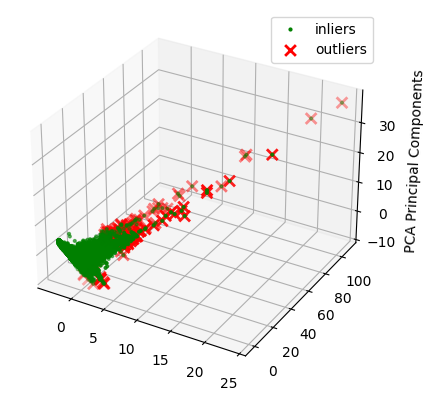

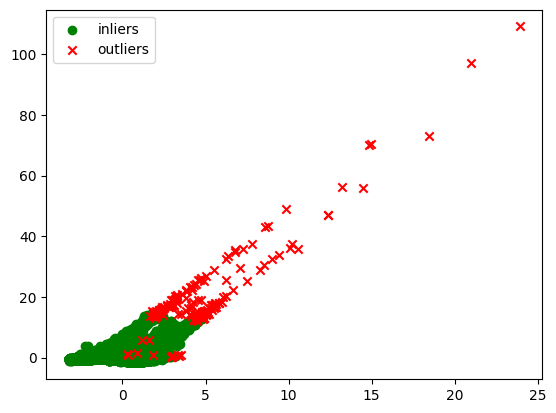

In [124]:
visualise(df_fraud, fraud_indices)

In [40]:
len(fraud_indices)/np.shape(df_fraud)[0]

0.05000541314311147

In [125]:
df_fraud

,Amount,Balance,Decimal_time,weekday,Trend,Time_diff,percentile_of_business,0,1,2,3
0,-7.502333,0.843403,-2.552375,-1.463070,0.177120,-0.669006,-2.166367,-0.917146,-0.170168,1.077791,-0.235110
1,0.132065,0.830720,1.510060,-1.463070,0.140708,-0.651929,-2.166367,-0.917146,-0.170168,1.077791,-0.235110
2,0.076960,0.753841,-1.308096,0.683494,0.198810,0.350266,-2.166367,-0.917146,-0.170168,1.077791,-0.235110
3,0.242089,0.711584,0.363294,-1.463070,0.218633,-0.258095,-2.166367,-0.917146,-0.170168,1.077791,-0.235110
4,0.248977,0.739848,0.962031,-1.463070,0.205240,-0.125750,-2.166367,-0.917146,-0.170168,1.077791,-0.235110
...,...,...,...,...,...,...,...,...,...,...,...
166257,-1.523263,0.515455,-0.426569,-1.463070,0.044160,-0.631650,-2.166367,1.090339,-0.170168,-0.927824,-0.235110
166258,-0.164120,0.723806,1.168760,0.683494,0.009672,-0.575083,-2.166367,1.090339,-0.170168,-0.927824,-0.235110
166259,-0.577125,0.513167,1.198015,0.683494,-0.492953,-0.036096,-2.166367,-0.917146,5.876535,-0.927824,-0.235110
166260,0.120585,0.607112,-0.705459,-1.463070,0.147912,0.341728,0.417114,1.090339,-0.170168,-0.927824,-0.235110


# EM MV Testing

In [137]:
def test_iforest(temp, co_):
        n_generated = 100000
        alpha_min = 0.9
        alpha_max = 0.999
        t_max = 0.9

        np.random.seed(1)

        plt.clf()
        plt.figure(figsize=(25, 13))

        # loading and vectorization
        X= np.array(temp)

        n_samples, n_features = np.shape(X)
        n_samples_train = n_samples // 2
        n_samples_test = n_samples - n_samples_train

        X_train = X[:n_samples_train, :]
        X_test = X[n_samples_test:, :]

        # define models:
        iforest = IsolationForest(n_estimators=100,max_features=1.0, contamination=co_)

        lim_inf = X.min(axis=0)
        lim_sup = X.max(axis=0)
        volume_support = (lim_sup - lim_inf).prod()
        t = np.arange(0, 100 / volume_support, 0.01 / volume_support)
        axis_alpha = np.arange(alpha_min, alpha_max, 0.0001)
        unif = np.random.uniform(lim_inf, lim_sup,
                                size=(n_generated, n_features))

        # fit:
        print('IsolationForest processing...')
        iforest = IsolationForest()
        iforest.fit(X_train)
        s_X_iforest = iforest.decision_function(X_test)
 
        s_unif_iforest = iforest.decision_function(unif)
        plt.subplot(121)
        em_auc_iforest, em_iforest, amax_iforest = em(t, t_max,
                                                volume_support,
                                                s_unif_iforest,
                                                s_X_iforest, n_generated)


 
        amax = amax_iforest
        plt.subplot(121)
        plt.plot(t[:amax], em_iforest[:amax], lw=1,
                label='%s (em_score = %0.3e)'
                % ('iforest', em_auc_iforest))

        plt.ylim([-0.05, 1.05])
        plt.xlabel('t', fontsize=20)
        plt.ylabel('EM(t)', fontsize=20)
        plt.title('Excess-Mass curve', fontsize=20)
        plt.legend(loc="lower right")


        plt.subplot(122)
        mv_auc_iforest, mv_iforest = mv(axis_alpha, volume_support,
                                        s_unif_iforest, s_X_iforest, n_generated)

        plt.plot(axis_alpha, mv_iforest, lw=1,
                label='%s (mv-score = %0.3e)'
                % ('iforest', mv_auc_iforest))

        # plt.xlim([-0.05, 1.05])
        # plt.ylim([-0.05, 100])
        plt.xlabel('alpha', fontsize=20)
        plt.ylabel('MV(alpha)', fontsize=20)
        plt.title('Mass-Volume Curve', fontsize=20)
        plt.legend(loc="upper left")


        plt.show()

        return(em_auc_iforest, mv_auc_iforest)


IsolationForest processing...

 failed to achieve t_max 



<Figure size 640x480 with 0 Axes>

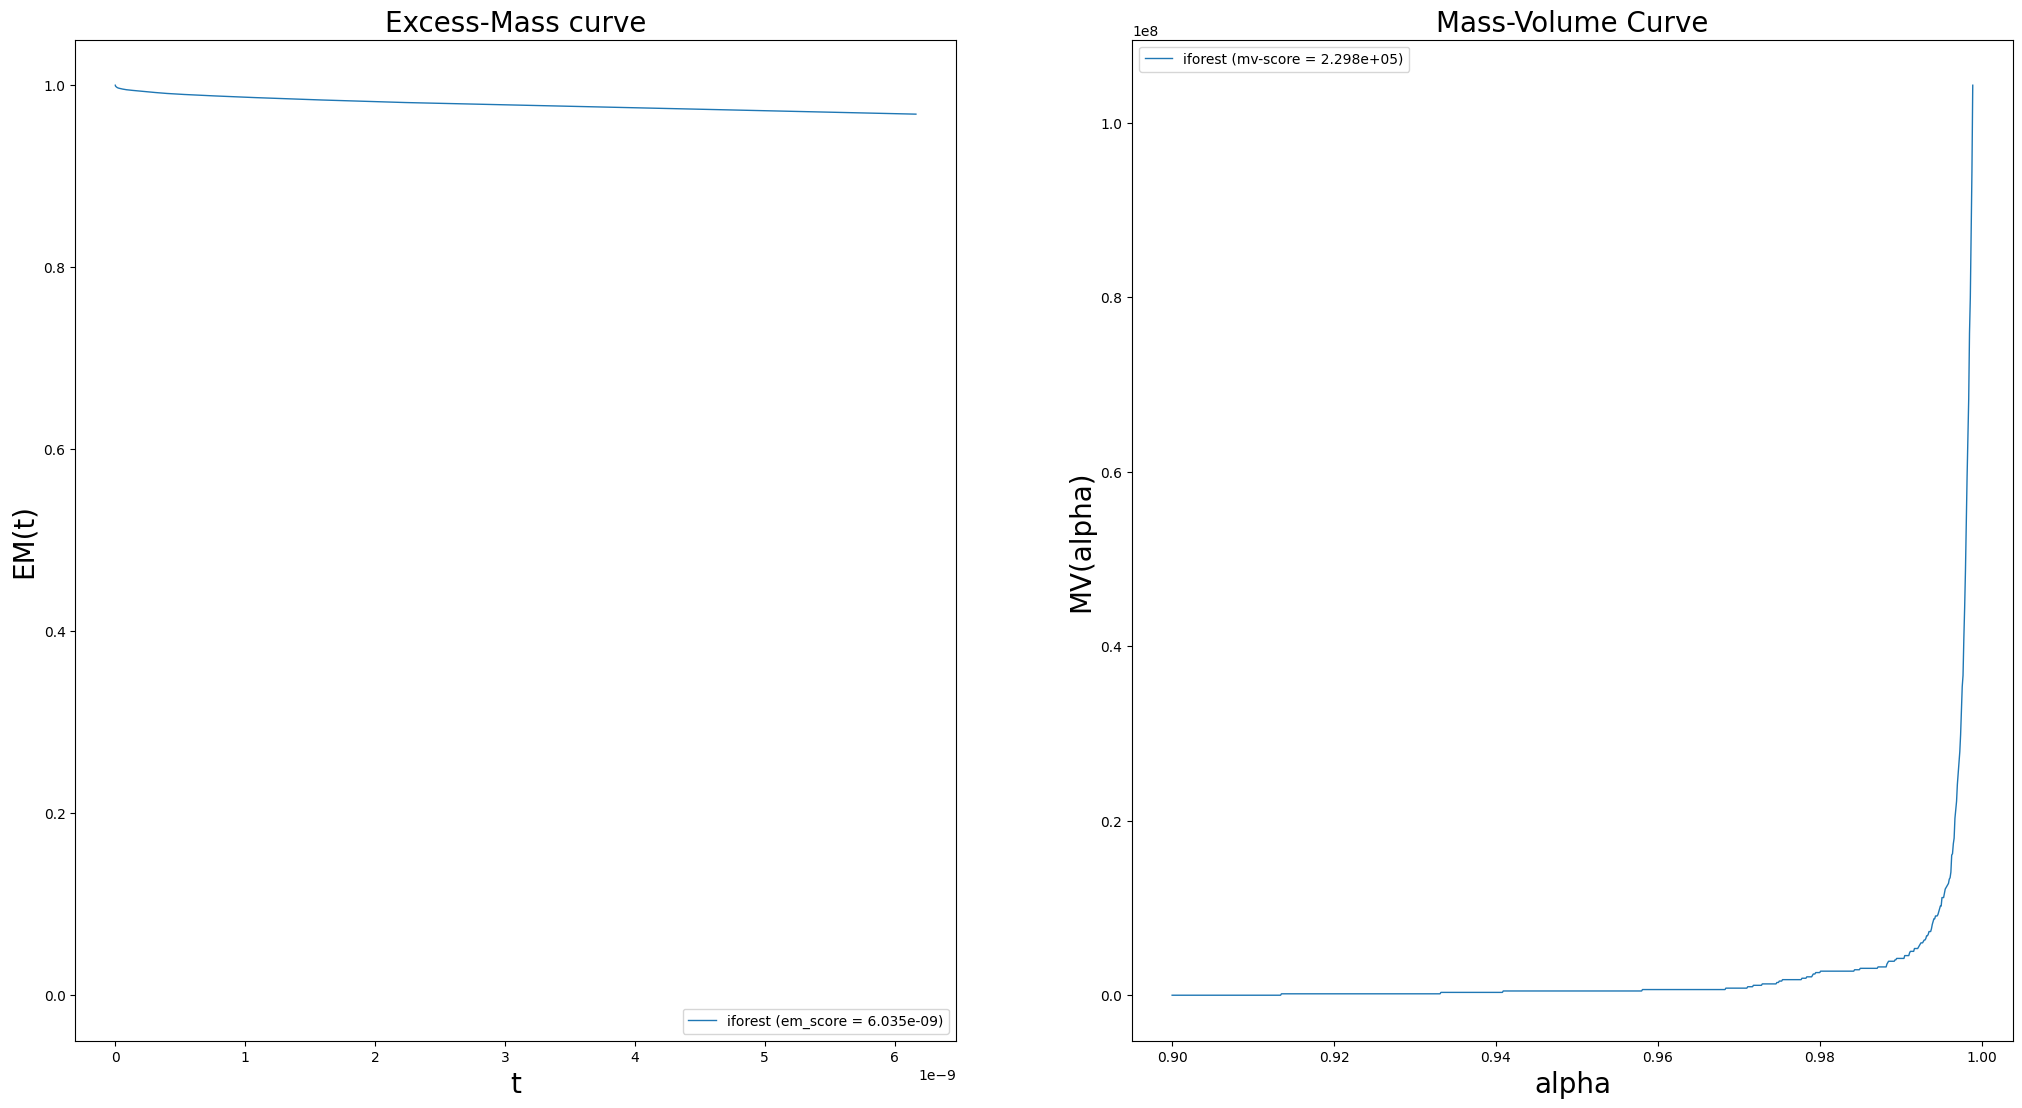

(6.035026732957173e-09, 229834.2213788457)

In [134]:
test_iforest(df_fraud, 5/1000)


IsolationForest processing...

 failed to achieve t_max 



<Figure size 640x480 with 0 Axes>

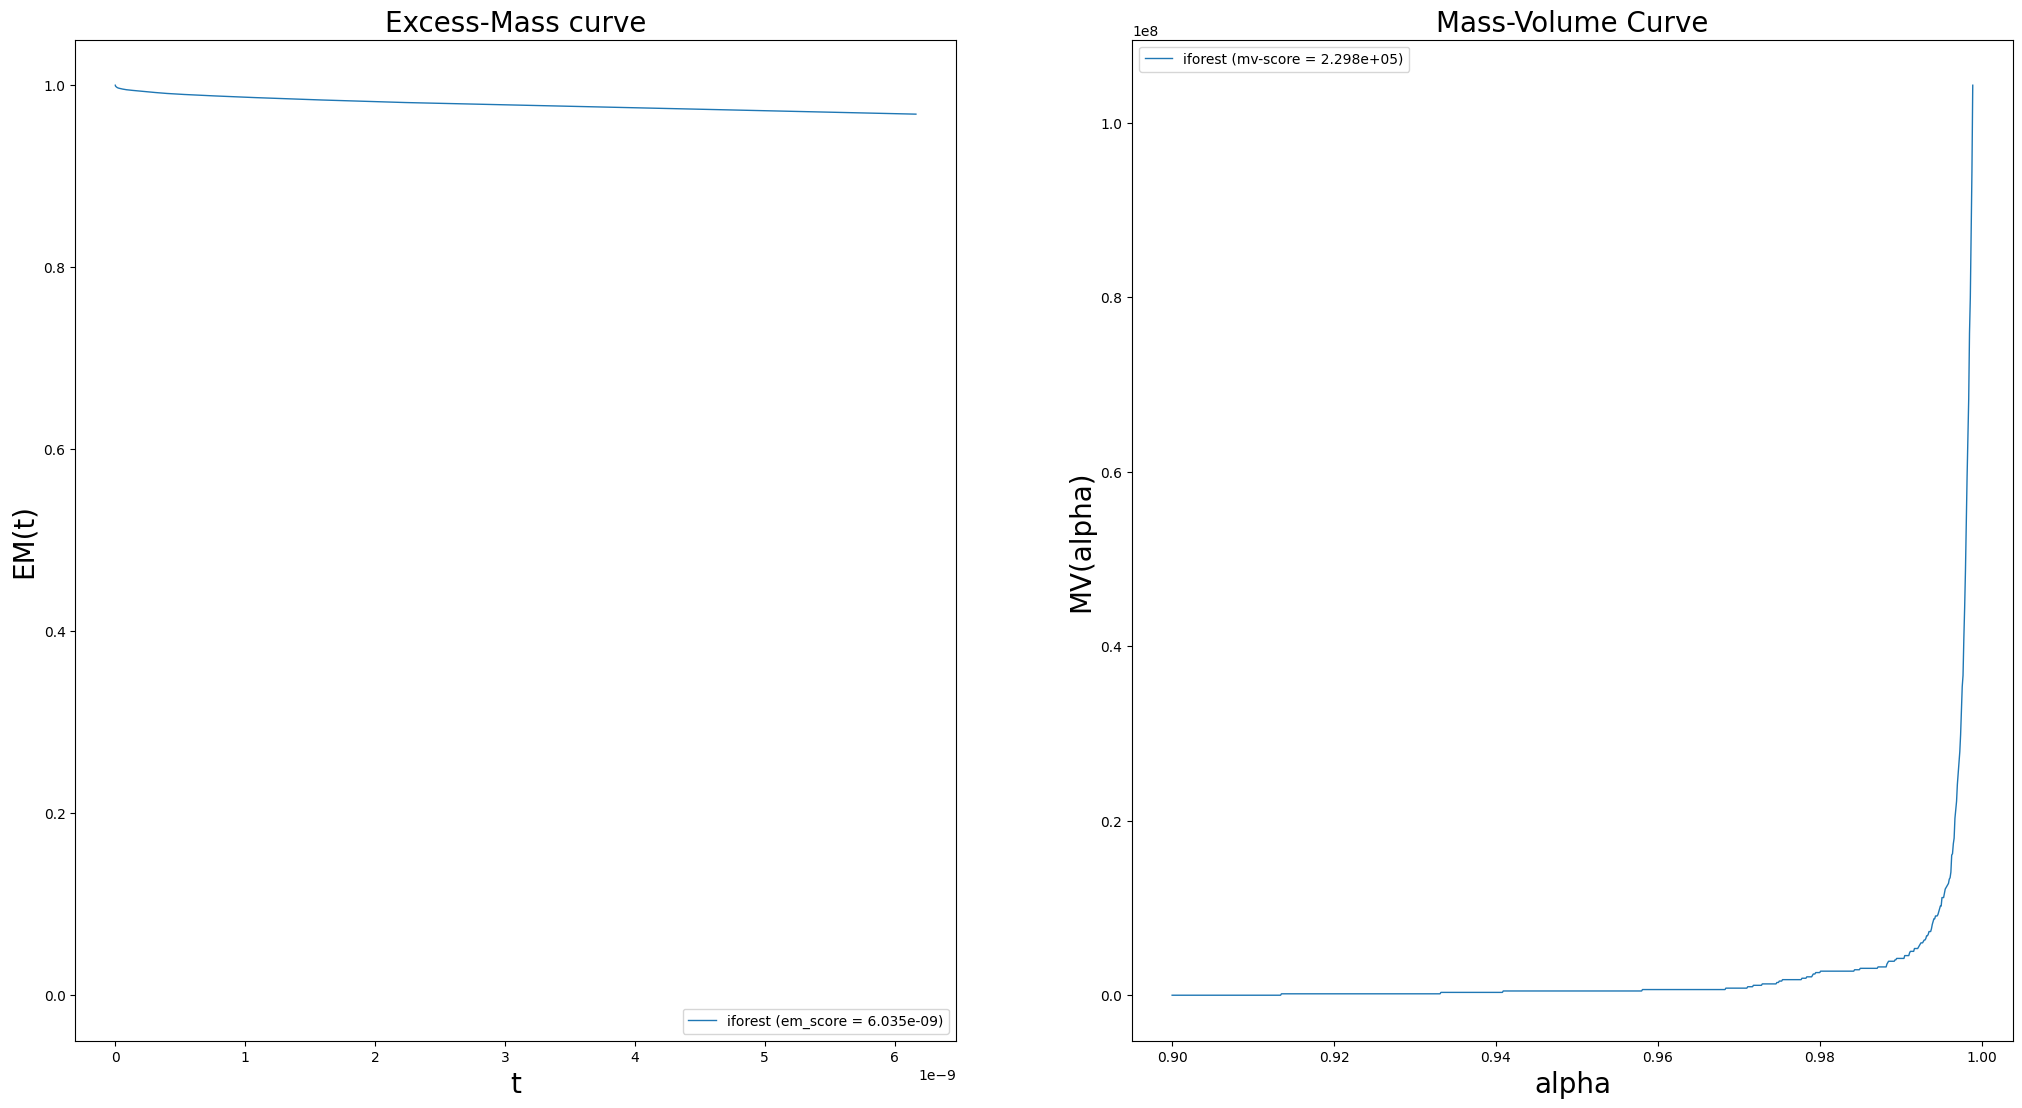

(6.035026732957173e-09, 229834.2213788457)

In [138]:
test_iforest(df_fraud, 7/1000)

IsolationForest processing...

 failed to achieve t_max 



<Figure size 640x480 with 0 Axes>

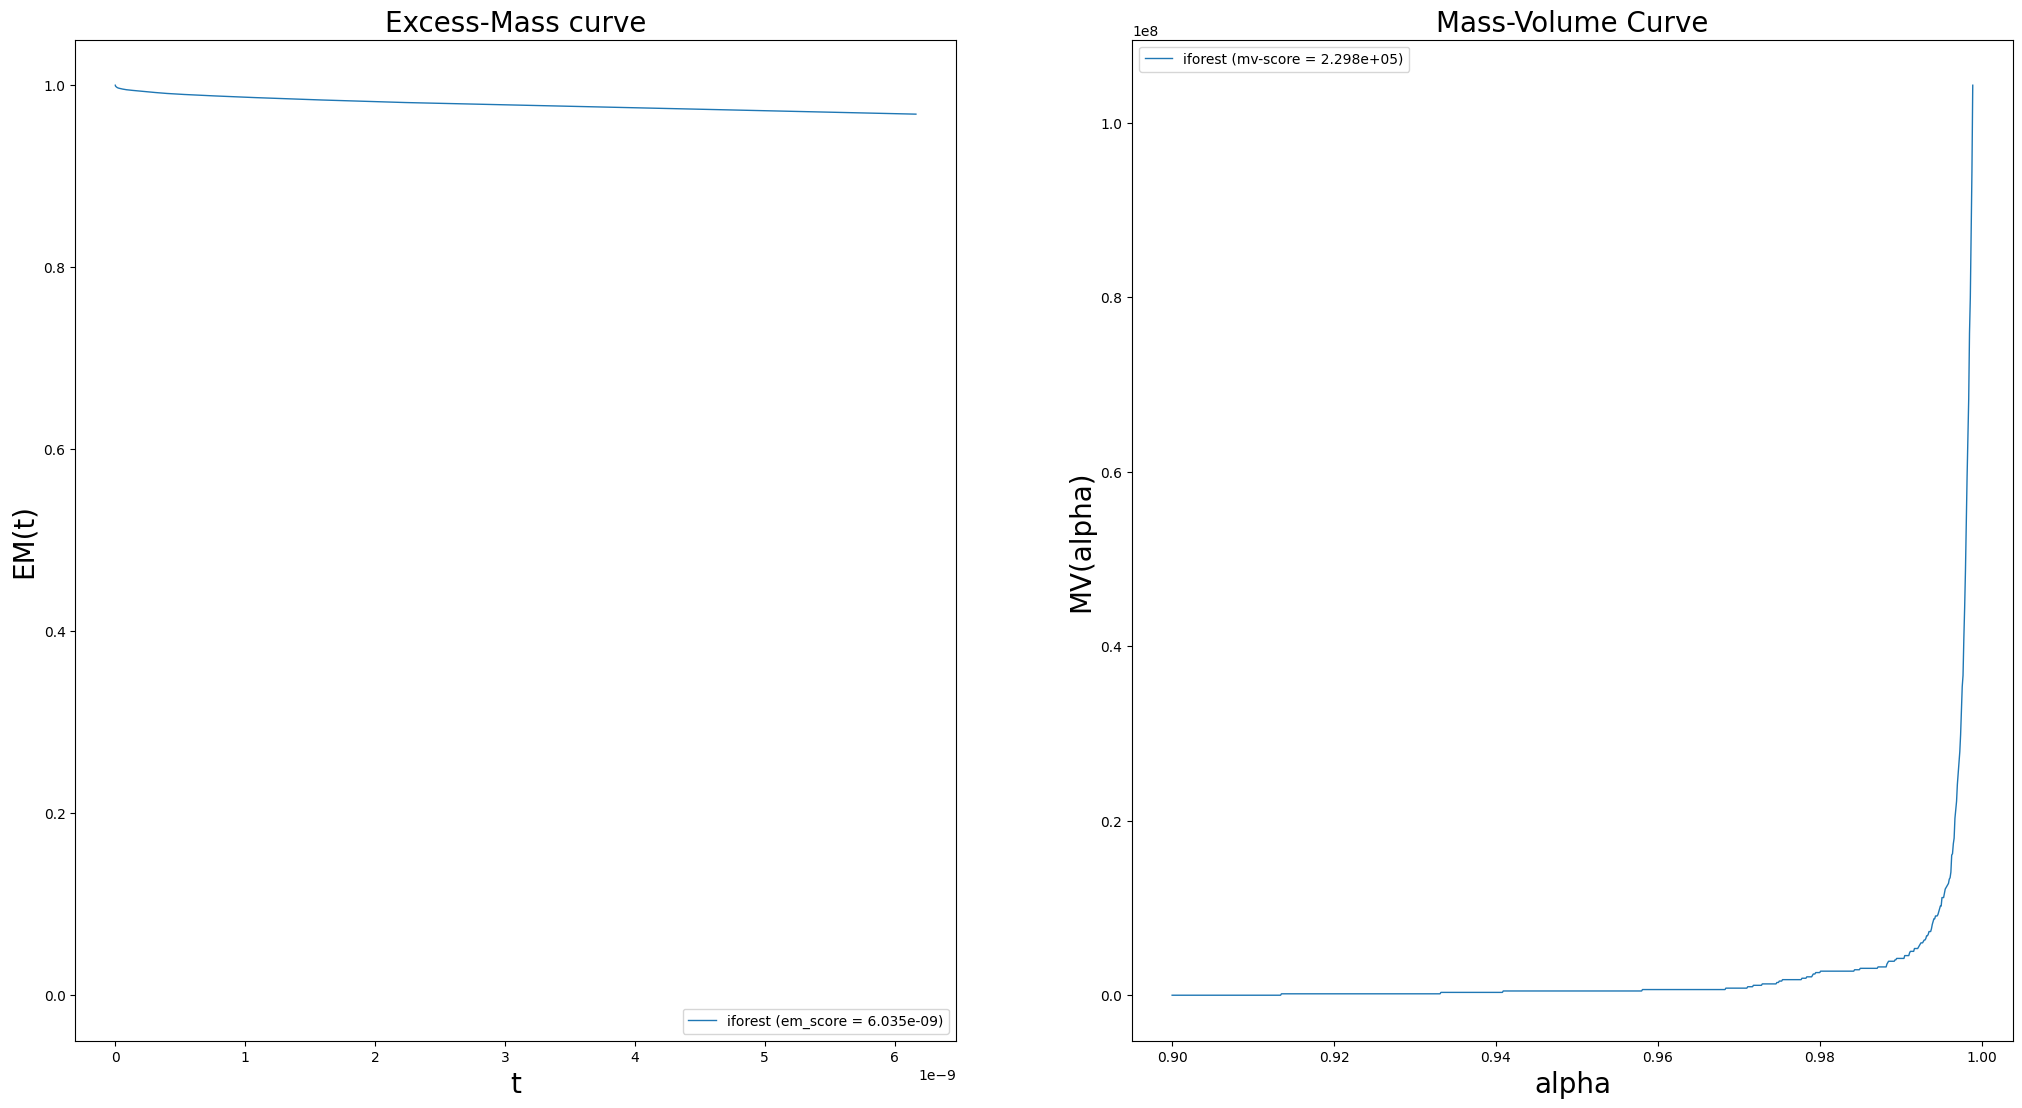

(6.035026732957173e-09, 229834.2213788457)

In [139]:
test_iforest(df_fraud, 1/100)